# Folk repository (necessary)

## https://github.com/ReBachtr/whale_identification

# Download data (not necessary)

### Download data from https://www.kaggle.com/c/humpback-whale-identification/data


### Follow the instruction of https://github.com/Kaggle/kaggle-api, then implement the following code

In [ ]:
! kaggle competitions download -c humpback-whale-identification

In [ ]:
! unzip -n train.zip -d ./whaletrain

In [ ]:
! python3 split_to_testset.py -i ./whaletrain -c test.csv -o ./whaletest

# Install packages

In [1]:
! pip install albumentations --user > /dev/null 2>&1
! pip install pretrainedmodels --user > /dev/null 2>&1

In [15]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import csv
from sklearn.neighbors import KNeighborsClassifier
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from torchvision import models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data

In [4]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./demo_test.csv")
train_df.head()

,Image,Id
0,b4284d5ef.jpg,w_16b5050
1,4b82a9fc0.jpg,new_whale
2,16bf136fb.jpg,w_e73cce3
3,9805abc71.jpg,w_d6fde02
4,4e2803603.jpg,w_83a4279


In [5]:
print(f"There are {len(os.listdir('./whaletrain'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('./demotest'))} images in test dataset with {test_df.Id.nunique()} unique classes.")

There are 20288 images in train dataset with 4571 unique classes.
There are 1015 images in test dataset with 454 unique classes.


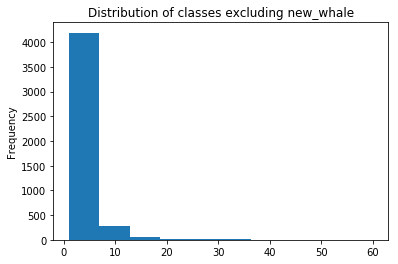

In [6]:
train_df.Id.value_counts()[1:].plot(kind='hist');
plt.title('Distribution of classes excluding new_whale');

In [7]:
def prepare_labels(y):
    # one_hot the label(Id)
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

y, le = prepare_labels(train_df['Id'])
y_ts, le_ts = prepare_labels(test_df['Id'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

# Data Loader

In [111]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [112]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [113]:
test_set = WhaleDataset(datafolder='./whaletest/', datatype='train', df=test_df, transform=data_transforms_test,y = y_ts)
batch_size = 32
num_workers = 0
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

# Predict with trained model

## Simple CNN

## Resnet-18

In [8]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

data_transforms = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [10]:
test_set = WhaleDataset(datafolder='./demotest/', datatype='train', df=test_df, transform=data_transforms_test,y = y_ts)
num_workers = 0
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [16]:
num_classes = 4571
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features #最后fc层的输入
model_conv.fc = nn.Linear(num_ftrs, num_classes) #NUM_CLASSES是自己数据的类别
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
model_conv.load_state_dict(torch.load('./model/Res18.pth'))

In [18]:
model_conv.cuda()
total = list(0. for i in range(test_df.Id.nunique()))
correct = list(0. for i in range(test_df.Id.nunique()))

accuracy = []
    
# Compute the test result
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()
    output = model_conv(data)
    predicted = torch.argmax(output, 1)

    res = (predicted == torch.argmax(target, 1)).squeeze()

    for label_idx in range(len(target)):

        label_single = torch.argmax(target, 1)[label_idx]
        correct[label_single] += res[label_idx].item()
        total[label_single] += 1

acc = sum(correct)/sum(total)
print(f'acc : {acc}')

acc : 0.4669950738916256


## Resnet-101

## Feature extractor

In [114]:
class Net_ext(nn.Module):
    def __init__(self, num_classes):
        super(Net_ext, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        return x

In [115]:
class autoencoder_ext(nn.Module):
    def __init__(self):
        super(autoencoder_ext, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=1),  
            nn.ReLU(True))
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.ReLU(True))
        self.pool2 = nn.MaxPool2d(3, stride=1, return_indices=True)  
        self.fc1 = nn.Linear(135424, 1024)
        self.fc2 = nn.Linear(1024, 135424)
        self.unpool2 = nn.MaxUnpool2d(3, stride=1)
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),  
            nn.ReLU(True))
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 7, padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder1(x)
        (x, ind1) = self.pool1(x)
        x = self.encoder2(x)
        (x, ind2) = self.pool2(x)
        
        x = x.view(-1, 135424)
        x = F.relu(self.fc1(x))
        return x

## CNN + knn

In [116]:
model_conv_ext = Net_ext(4571)
test_ext_1 = []
test_ext_2 = []
for batch_i, (data, target) in enumerate(test_loader):
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext.cuda()
    output = model_conv_ext(data)
    for i in range(len(output)):
        test_ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        test_ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30


IndexError: index 1015 is out of bounds for axis 0 with size 1015

### The IndexError here doesn't matter, since the demotest size is 1015 cannot be divided by batch size 32

### Show the feature extracted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


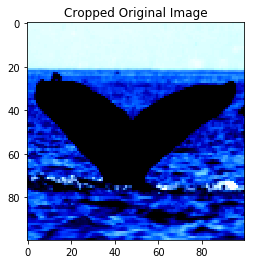

In [117]:
i = 12
x1 = test_ext_2[i][0]
b = cv2.merge([x1[0,:,:],x1[1,:,:],x1[2,:,:]])
plt.title('Cropped Original Image')
plt.imshow(b) 

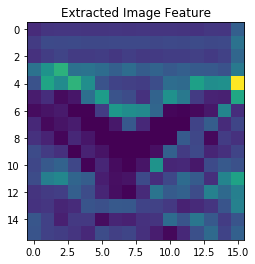

In [118]:
x = test_ext_1[i][0]
plt.title('Extracted Image Feature')
plt.imshow(x[6,:,:]) 

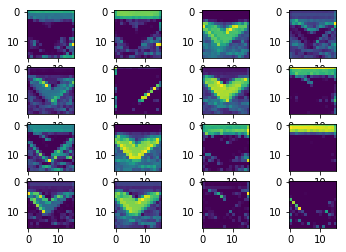

In [119]:
f_all = test_ext_1[i][0]
for i in range(16):
    plt.subplot(4,4,i+1)
    f_img = f_all[2*i,:,:]
    plt.imshow(f_img)

### Predict result

In [120]:
x_ts = np.zeros((len(test_ext_1), 16384))
y_n_ts = np.zeros(len(test_ext_1))
for i in range(len(test_ext_1)):
    x_ts[i, :]= test_ext_1[i][0].reshape(16384)
    y_n_ts[i] = np.argmax(test_ext_1[i][1].cpu().detach().numpy(),axis=0)

In [121]:
knn_conv = joblib.load("./model/knn_conv.m")
pred = knn_conv.predict(x_ts)
score = knn_conv.score(x_ts, y_n_ts)

FileNotFoundError: [Errno 2] No such file or directory: './model/knn_conv.m'

In [ ]:
i = 0
print(f'The prediction of {i}th image is {pred[i]}, which is {y_n_ts[i]}')
print(f'accuracy is {score}')

## Auto-encoder + knn

In [21]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=https://drive.google.com/file/d/1ohorCjRBg-d9dTYZBEViW_nlnOI6ce0E/view?usp=sharing' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=https://drive.google.com/file/d/1ohorCjRBg-d9dTYZBEViW_nlnOI6ce0E/view?usp=sharing" -O ./data/conv_autoencoder_imporved.pth && rm -rf /tmp/cookies.txt

--2019-06-08 15:55:38--  https://docs.google.com/uc?export=download&confirm=&id=https://drive.google.com/file/d/1ohorCjRBg-d9dTYZBEViW_nlnOI6ce0E/view?usp=sharing
Resolving web.ucsd.edu (web.ucsd.edu)... 132.239.1.230, 132.239.1.231
Connecting to web.ucsd.edu (web.ucsd.edu)|132.239.1.230|:3128... connected.
Proxy request sent, awaiting response... 404 Not Found
2019-06-08 15:55:38 ERROR 404: Not Found.



### The pre_trained model is too large to upload to git, which can be download by this link: https://docs.google.com/uc?export=download&id=https://drive.google.com/file/d/1ohorCjRBg-d9dTYZBEViW_nlnOI6ce0E/view?usp=sharing And please download it to ./model file.

In [122]:
#load model
model_ae_ext = autoencoder_ext().to(device)
model_ae_ext.load_state_dict(torch.load('./model/conv_autoencoder_imporved.pth'))
#extract features
test_ext_1 = []
test_ext_2 = []
for batch_i, (data, target) in enumerate(test_loader):
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_ae_ext.cuda()
    output = model_ae_ext(data)
    for i in range(len(output)):
        test_ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        test_ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30


IndexError: index 1015 is out of bounds for axis 0 with size 1015

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


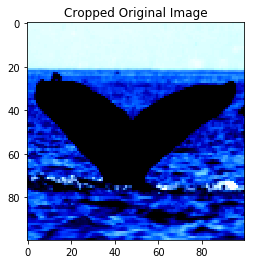

In [128]:
i = 12
x1 = test_ext_2[i][0]
b = cv2.merge([x1[0,:,:],x1[1,:,:],x1[2,:,:]])
plt.title('Cropped Original Image')
plt.imshow(b) 

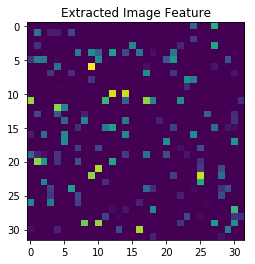

In [130]:
x = test_ext_1[i][0].reshape(32,32)
plt.title('Extracted Image Feature')
plt.imshow(x) 

In [123]:
#reshape to classifier        
x_ts = np.zeros((len(test_ext_1), 1024))
y_n_ts = np.zeros((len(test_ext_1)))
for i in range(len(test_ext_1)):
    x_ts[i, :] = test_ext_1[i][0].reshape(1, 1024)
    y_n_ts[i] = np.argmax(test_ext_1[i][1].cpu().detach().numpy(), axis = 0)

In [124]:
knn_ae = joblib.load("./model/knn_ae.m")
pred = knn_ae.predict(x_ts)
score = knn_ae.score(x_ts, y_n_ts)

In [125]:
i = 0
print(f'The prediction of {i}th image is {pred[i]}, which is {y_n_ts[i]}')
print(f'The accuracy is {score}')

The prediction of 0th image is 351.0, which is 22.0
The accuracy is 0.3659274193548387


## Auto-encoder + svm

In [126]:
svm_ae = joblib.load("./model/svm_ae.m")
pred = svm_ae.predict(x_ts)
score = svm_ae.score(x_ts, y_n_ts)

In [127]:
i = 0
print(f'The prediction of {i}th image is {pred[i]}, which is {y_n_ts[i]}')
print(f'The accuracy is {score}')

The prediction of 0th image is 2228.0, which is 22.0
The accuracy is 0.019153225806451613
